In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


KeyboardInterrupt: 

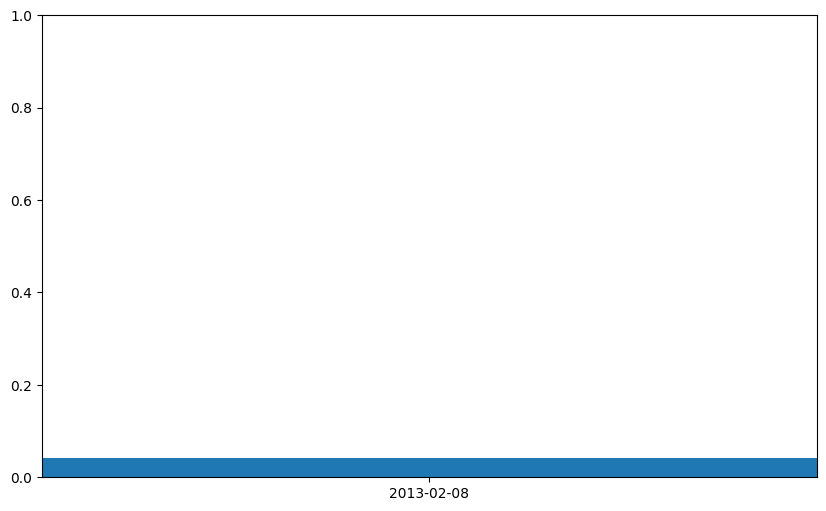

In [ ]:
df = pd.read_csv('all_stocks_5yr.csv')



df['daily_return'] = (df['close'] - df['open']) / df['open']
avg_return=df.groupby('Name')['daily_return'].mean()
avg_open = df.groupby('Name')['open'].mean()
avg_close = df.groupby('Name')['close'].mean()

df_avg = pd.DataFrame({
    'avg_open': avg_open,
    'avg_close': avg_close,
    'avg_return': avg_return
}).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['daily_return'], width=0.5)
plt.xlabel('Stock')
plt.ylabel('Average Daily Return')
plt.title('Average Daily Return by Stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#for each stock we create a variable that stores its price change daily, then we calculate varaince

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Step 1: Load your data
df = pd.read_csv('all_stocks_5yr.csv')

# Step 2: Calculate daily returns
df['daily_return'] = (df['close'] - df['open']) / df['open']

# Step 3: Filter the data for a specific stock, e.g., 'AAL'
aal_data = df[df['Name'] == 'AAL']

# Step 4: Calculate the expected value (mean) and variance of daily returns
expected_value_daily_return = aal_data['daily_return'].mean()
variance_daily_return = aal_data['daily_return'].var()
std_dev_daily_return = np.sqrt(variance_daily_return)

# Step 5: Use the Central Limit Theorem (CLT)
# Assume we want the probability of profit for a single day (n=1)
n = 1
mean_clt = expected_value_daily_return
std_clt = std_dev_daily_return / np.sqrt(n)

# Step 6: Calculate the Z-score for a profit (daily return > 0)
profit_threshold = 0
z_score = (profit_threshold - mean_clt) / std_clt

# Step 7: Use the Z-table (standard normal distribution) to find the probability
probability_of_profit = 1 - stats.norm.cdf(z_score)

print("Expected Value of Daily Return for AAL:", expected_value_daily_return)
print("Variance of Daily Return for AAL:", variance_daily_return)
print("Probability of Generating a Profit for AAL:", probability_of_profit)


Expected Value of Daily Return for AAL: 0.00031150141839557643
Variance of Daily Return for AAL: 0.00038401953040406907
Probability of Generating a Profit for AAL: 0.5063412539979415
